# Analyzing FUMBBL Blood Bowl team strength using Python

This blogpost is about **Blood Bowl**, a boardgame I finally started playing last year. The goal of this blog post is to use the `pandas` and `plotnine` Python packages to analyse and visualise the [public dataset of matches I have put together](Link/to/other/blog/post).

Blood bowl is a game of Fantasy Football, where not all teams (think "Orcs" or "Elves") are equally strong. There exists a lively tournament scene. Most tournaments make some effort in order to create a more level playing ground for the different teams to compete. Doing so requires knowledge of the relative team strength when using the official ruleset.

In 2020, a new version of the Blood Bowl board game came out with several changes to the rules, and to the available teams to play with.
In september 2021, the online Blood Bowl gaming website **FUMBBL** switched to the new ruleset ("BB2020"), with players largely abandoning the previous ruleset (from 2016, "BB2016" hereafter). 

With a daily game volume of a few hundred matches, I decided it would be interesting to analyse the win rates of the different teams (or "races", given the fantasy world setting), and how these have been impacted by the new ruleset. In gaming, it is common to see rule changes where something can get **nerfed** (made weaker) or **buffed** (made stronger). The goal of changes are common in any gaming community, in an attempt to achieve more balance in the game. 

We examine whether the current "three tier" system to balance the strength differences between teams is optimal. The results can inform changes that improve balance.


# Python packages used in this blog post

This blogpost is written as a Jupyter notebook, and is fully reproducible. The idea is to make Blood Bowl data analysis accessible to others. Using only open source tooling reduces the barriers for others to take what i created and build on it. Apart from having Python installed, you need a code editor. Jupyter Notebooks can be read by many code editors, such as Jupyterlab, or Pycharm, i decided to try out [Visual Studio Code](https://code.visualstudio.com/), or **VS code** for short. It ticks all my boxes such as being cross platform (I use linux at home and Windows at work), being open source, and having a large user base, as [visible on Github](https://github.com/microsoft/vscode) with more than 125K stars. It works pretty well, the only thing I really miss is have a [Python console connected to the same kernel my Notebook is running on](https://stackoverflow.com/questions/54987778/is-it-possible-to-link-the-interactive-python-window-to-a-running-jupyter-notebo).

In [1]:
import random
import time

import pandas as pd
import numpy as np
import plotnine as p9

# Function for computing confidence intervals
from statsmodels.stats.proportion import proportion_confint   



# Introduction to Blood Bowl

Blood Bowl is a two player game on a board, with playing pieces, like Chess. But instead of two medieval kingdoms fighting, Blood Bowl is about fantasy football, say Tolkien meets rugby. It appealed to me as a teenager (I bought the game in 1994) because it combined the Warhammer playing pieces I liked so much (miniature models "minis" of Orcs, Elves, Dwarves etc) with simple game mechanics, but resulted in complex gameplay. Blood bowl requires a lot of skill to play well, with complex strategic decision making with a lot of uncertainty (heavy dice rolling involved). Blood Bowl is very much alive nowaydays: Over the timespan of a few decennia, an international gaming community has formed around the game, with a players' association, the NAF, with thousands of members, a World championship every two years, and with new editions and models being released on a regular basis. Blood Bowl is not only a game, it is also a sport, [like Chess](https://www.chess.com/article/view/is-chess-a-sport).
And with all sports, statistics is not far away. So lets dive in the world of Blood Bowl stats nerdery.

# Not all teams are created equal: tiers in Blood Bowl

There are around 25 "official" races / different teams, such as orcs, elves, humans etc.
Each race has different player types, with different strength, abilities, skills, etc.

As already mentioned above, Blood Bowl is not balanced with respect to the (30) different team "races" available. For example, it is much harder to win a match playing with a **Vampires** team, compared to playing with an **Orc** team. Not surprisingly, teams that have a higher probability of winning are more popular both in Tabletop tournaments as well as online at FUMBBL. 

Below I made a visualization of these three groups, as well as the new BB2020 tiers per the 2020 rulebook, and per the update of November 2021. For **Humans** and **Old World Alliance** the NAF and GW appear to differ from opinion, as a [oktober NAF online tournament](https://fumbbl.com/p/group?op=view&group=9298) places them in Tier 2, whereas the rulebook has them both in Tier 1.

[According to Games Workshop](https://www.warhammer-community.com/2021/11/29/the-only-thing-arriving-with-a-bigger-bang-than-barik-farblasts-bazooka-is-todays-blood-bowl-faq/):

*With tournaments starting to pick up again, we want coaches to get the best experience, partly through assessing the tiers of each of the teams. Some Tier 2 teams are performing well above what we expected, while some Tier 1 teams are languishing in the doldrums of the lower mid-table.*

In [2]:
race_tiers = pd.read_excel('data/race_tiers_mapping.xlsx',  engine='openpyxl')
race_tiers = race_tiers[ ['race_name', 'bb2020_tier', 'naf_tier', 'bb2020_nov21_tier']]
race_tiers = race_tiers.dropna()
# format for plotnine
race_tiers_long = pd.melt(race_tiers, id_vars='race_name', value_vars=['bb2020_tier', 'naf_tier', 'bb2020_nov21_tier'])


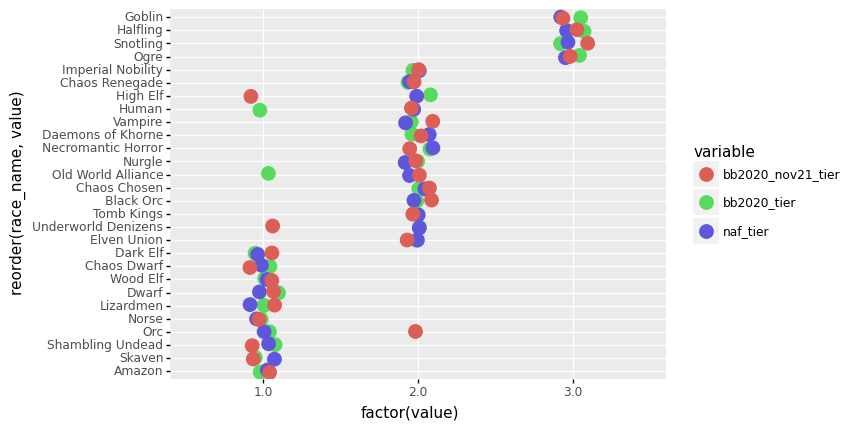

<ggplot: (-9223363257898514428)>

In [6]:
(p9.ggplot(data = race_tiers_long, mapping = p9.aes(x = 'reorder(race_name, value)', y = 'factor(value)', group = 'variable', color = 'variable'))
    + p9.geom_jitter(size = 5, width = 0.1, height = 0.1) 
    + p9.coord_flip())
    

Most NAF sanctioned tournaments use some form of tiering, but there exists a lot of variation in how this is implemented.
From the [rules for obtaining NAF sanctioning](https://www.thenaf.net/wp-content/uploads/2020/11/NAF_Tournament_Approval_Document_2021.pdf):

```
Individual rules variations in tournaments are permitted, even encouraged. This is 
in order to give each tournament its individual character.
[...]
Modifications should not radically affect the existing balance between 
races, but incentives may be given to the traditionally less-competitive 
teams, provided this is in moderation. 
```

For example, for the [World Cup in Austria (2019)](http://www.nafworldcup.sbbm-turniere.com/EN/WC4Rules.html), the Tier 2 teams above were further split up, giving four tiers in total. However, there are also tournaments (such as the [Dutch Open](https://sites.google.com/view/dutchopen/homepage?authuser=0) ) that directly use the official Rulebook + Errata tiers.

# Analyzing NAF data

Because there is all this variation in tiering rules for NAF tournaments, it is difficult to draw conclusions from NAF match data.
We can still try though.

Here are the win rates (with a draw counted as half a point) for BB2020 NAF tournaments. These were taken from the [NAF Tableau pages](https://public.tableau.com/app/profile/mike.sann0638.davies/viz/NAFGames_0/Variety) and contain match outcomes of all NAF tournaments since december 2020 using the new ruleset. 
I added uncertainty intervals assuming a simple "coin flip" process with a fixed probability of succes *p*, where i use for *p* the probability of succes that is calculated from the data. This gives us some indication of what variation to expect given the match volumes in the NAF database.

In [4]:
df_naf = pd.read_csv('data/W_Race_Record_Full_Data_data_bb2020.csv', na_values = '')

df_naf = df_naf.rename(columns={"Race": "race_name", 
                                "Variant": "ruleset_version", 
                                "Win %": "wins"})

# transform wins to 0, 0.5 or 1 numeric
df_naf['wins'] = df_naf['wins'].str.replace('%$', '')
df_naf['wins'] = df_naf['wins'].fillna(0).astype(float).astype(np.int64)
df_naf['wins'] = df_naf['wins']/100

# add tiers
df_naf = pd.merge(df_naf, race_tiers, on='race_name', how='left')

# Tidyverse-like data analysis with Pandas and plotnine

Doing most of my day to day analysis in `R`, i am (by now) used to the tidyverse philosophy of breaking things up in small steps, with each step on a separate line, and in order of execution (from left to right, top to bottom). Luckily, the `Pandas` data analysis library allows us to do something similar, here it is called `method chaining`.
The idea is that a Pandas object has methods for all the small operations we want to perform, and the python language that allows chaining these methods together.

Here we demonstrate this by calculating average win percentage by race, and calling this result `perc_win`.


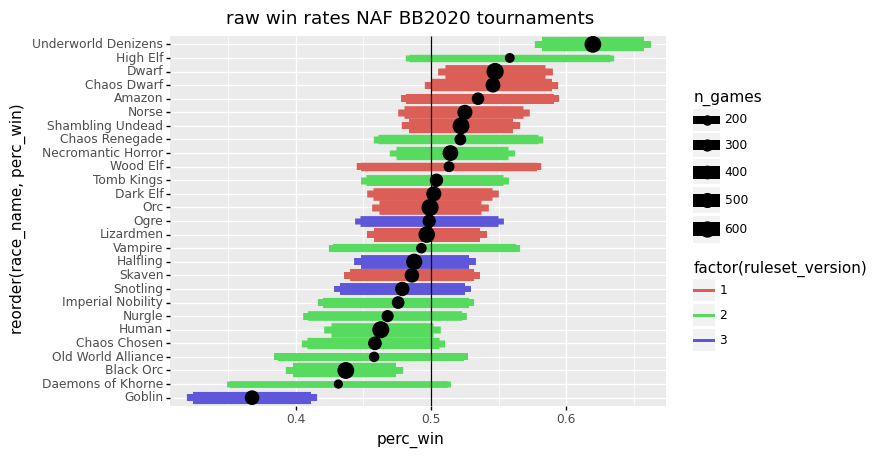

<ggplot: (8753000471251)>

In [5]:
res = (df_naf
    .groupby(['race_name', 'ruleset_version', 'naf_tier'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_wins = ('wins', "sum"),
        n_games = ('race_name', "count")
    )
    .sort_values( 'n_games', ascending = False)
    .reset_index()) # this adds the group by variables (now index) as a column

res = res.dropna()


res['lower_CI'], res['upper_CI'] =  proportion_confint(
                                      count = round(res['n_wins']).astype(int),
                                      nobs = res['n_games'],
                                      alpha = 0.05
                                  )

(p9.ggplot(data = res, mapping = p9.aes(x = 'reorder(race_name, perc_win)', y = 'perc_win', 
size = 'n_games', group = 'factor(ruleset_version)', color = 'factor(ruleset_version)'))
    + p9.geom_errorbar(p9.aes(ymin = 'lower_CI', ymax = 'upper_CI', color = 'factor(naf_tier)'))
    + p9.geom_point(colour = "black" )
    + p9.scale_size_area() 
    + p9.coord_flip()
    + p9.geom_hline(yintercept = 0.5)
    + p9.ggtitle("raw win rates NAF BB2020 tournaments"))


We can see that, even with most tournaments having some form of tiering, there are still teams that win (in) NAF tournaments more often than others. For example, this quote is from the most recent ["NAF tournament report"](https://www.thenaf.net/rankings/elo-ranking/tableau/the-naf-report-2/):

```
Underworld continued to dominate in October, winning the two largest tournaments and maintaining the greater than 60% win ratio.  This is
generally due to swarming giving them more players on the pitch and the use of Hakflem and Morg'n'Thorg. (N.b. these are special "Star Players" that can be added to teams)
```

This is exactly what we see above in the NAF data. At the same time, we see that in the NAF tournaments, **Skaven** (A tier 1 team) win equally often as **Ogres**, a tier 3 team. This could very well be because of the tiering systems being used. (Of course, it could also be that with more data, **Skaven** would in fact have a win rate that is a few percentage higher.)

However, the best way to learn about the teams relative strength is in the absence of any tiering. Then we can directly interpret the win rates as measuring relative team strength. For this, we turn to online Blood Bowl, and more specific, to **FUMBBL**!

# Blood Bowl online: FUMBBL 

Blood Bowl can also be played online. A paid version called "Blood Bowl 2" with appealing 3D graphics is available on [Steam](https://store.steampowered.com/app/236690/Blood_Bowl_2/). However, a more basic (2D) version is available as [FUMBBL](https://fumbbl.com). It uses a Java client that uploads game results to an online server with an accompanying website that supports the managerial and community aspects of the game (Forming teams, using winnings to buy new players, displaying statistics such as coach rankings, organizing tournaments, forum discussions etc).
The name **FUMBBL** is likely a wordplay on the combination of fumble (losing the ball in American Football) and BBL which stands for Blood Bowl League.

The **FUMBBL** website (https://fumbbl.com) is one big pile of data. From coach pages, with their teams, to team rosters, with players, and match histories. It's all there.
And the nice thing of **FUMBBL**, for our purpose, is that it has several divisions where all teams start out equal, i.e. there is no tiering system in place.
This allows us to learn what the relative team strengths are purely under the official Blood Bowl rules as published by Games Workshop.

We load the **FUMBBL** match outcome datasets that I have compiled and constructed, as documented in [a separate blog post](link/to/blog).

In [6]:
# PM Load the four prepped datasets
target = 'data/df_matches_final.h5'
df_matches = pd.read_hdf(target) 

target = 'data/df_wins_final.h5'
df_wins = pd.read_hdf(target) 

target = 'data/inducements_final.h5'
inducements = pd.read_hdf(target) 

# First analysis: Orcs are most popular!

Which races are the most popular on FUMBLL in the last year?
For this, we need only to count which races were chosen how many times.

However, since each match contains two teams, we need to create a new dataframe `df_races`, double in size, that contains for each row the `match_id` and `team_race` of one of the two teams.

In [7]:
team1_races = df_matches[['match_id', 'team1_race_name']]
team2_races = df_matches[['match_id', 'team2_race_name']]

# make column names equal
team1_races.columns = team2_races.columns = ['match_id', 'race_name']

# row bind the two dataframes
df_races = pd.concat([team1_races, team2_races])

# aggregate by race_name
res = (df_races
        .groupby(['race_name'])
        .size()
        .reset_index(name='n_games')
)

# select most popular races for filtering
top_races = res.loc[(res.n_games > 1000)]['race_name']



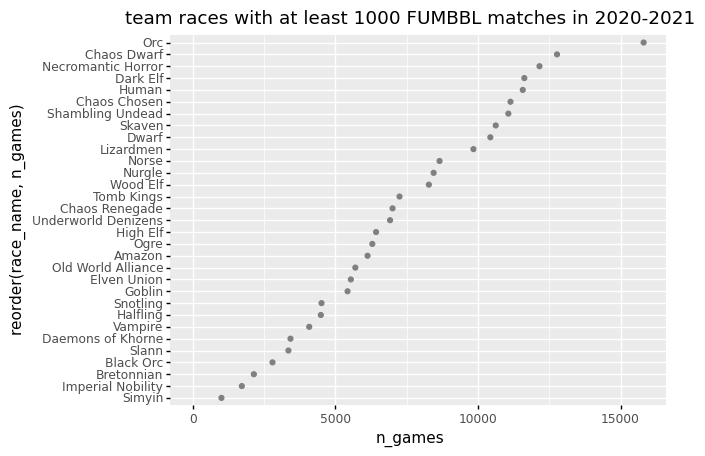

<ggplot: (8752951049287)>

In [8]:
(p9.ggplot(data = res.loc[res['race_name'].isin(top_races)], mapping = p9.aes(x = 'reorder(race_name, n_games)', y = 'n_games'))
    + p9.geom_point(colour = 'gray') 
    + p9.expand_limits(y = 0)
    + p9.coord_flip()
    + p9.ggtitle('team races with at least 1000 FUMBBL matches in 2020-2021'))

So the orcs are most popular! Here we should keep in mind that we have pooled all the FUMBBL matches of last year. Of course, Black Orcs and Imperial Nobility are new BB2020 teams, having only been available on FUMBBL since september 2021.
And daemons of Khorne, Slann and Bretonnian are not available in two large FUMBBL divisions.


# Match outcomes: How much is a draw worth?

If we want to calculate a win rate for each race, we need to decide what to do with draws.
I've never given the matter much thought, but it turns out other people have!

For example, in football, there is a popular weighting scheme where wins are given 3 points, draws 1 point and losses 0 points.
This is called [three points for a win](https://en.wikipedia.org/wiki/Three_points_for_a_win) . 
In Blood bowl leagues and tournaments, this rule is often used as well.
So, if we want to predict which teams perform best in these settings (have the highest probability of winning a tournament), we need to weigh the match outcomes accordingly.

However, in Blood Bowl data analysis, it seems that a 2:1:0 (W / D / L) weighting scheme is most commonly used. 
This scheme has the advantage that the weighted average win percentage over all matches is always 50%, creating a nice reference point allowing conclusions such as this and that team has an x percent above average win percentage.

For example, Mike Davies from the NAF calculates win rate by weighting each win as 1 point, and each draw as 0.5 points (For example, [here](https://public.tableau.com/app/profile/mike.sann0638.davies/viz/NAFGames_0/SuccessBB2020)).

So if we want to compare with others, it makes sense to adapt this scheme as well.

# Selecting the divisions and leagues to analyse

FUMBBL allows coaches to create their own rulesets to play their own leagues and tournaments with. For example, there is a so-called "Secret League" where coaches can play with "Ninja halflings", of with "Ethereal" spirits etc. 

Since we want the team strength for the official rulesets BB2016 and BB2020, we need to drop the matches that are played under different rules.

Lets have look at the various divisions and leagues, which rulesets are used, and which races are played how often.
There are a lot of small leagues being played on FUMBBL, they account for maybe X% of all the matches.

We only look at divisions and leagues with a sufficient volume of matches, or otherwise we do not have sufficient statistics for each race.

So I aggregated the data by division, league and ruleset, and filtered on at least 150 different teams that have played at least once last year.
Apart from the main "Divisions" that are part of FUMBBL, there were a few user-run leagues present in this table, so I looked up their names on FUMBBL and what ruleset is used (BB2016, BB2020 or some other variant). This information (contained in an xlsx) is added to the dataset below.

PM CHANGE TO DF_MATCHES MAKES MORE SENSE AS WELL


In [7]:
(df_matches
    .groupby(['ruleset', 'league', 'division_id', 'division_name',  'ruleset_version'], dropna=False)
    .agg( n_teams = ('ruleset', 'count')
    )
    .sort_values('n_teams', ascending = False)
    .query('n_teams > 150')['n_teams']
    .reset_index()
)

NameError: name 'df_matches' is not defined

We are primary interested in the new BB2020 ruleset version. We see that apart from the new **Competitive** division of FUMBBL itself, already a few user run leagues have started to use BB2020 rules. However, I chose to not include these leagues in the comparison: 

* Both NAF and Lega Gladio tournaments consist of a mix of BB2016 and BB2020 matches, making these more difficult to analyse. 
* Then there is the Secret League, which is different because of all the extra teams available there. 
* Test Open League BB2020 has likely been the test group before the Competitive Division became available.

The NAF tournaments current ruleset is interesting, because it introduces (for the first time) tiers in FUMBBL!
The NAF online tournament allows coaches to distribute a fixed number of skills, depending on the team's tier.
This makes match outcomes in this league less comparable to other divisions on FUMBBL.

Then on to the BB2016 ruleset. Here we have three big FUMBBL divisions: Blackbox, Ranked and (regular) League.
Blackbox and Ranked use ruleset 1. FUMBBL has a nice display of a rulesets, see e.g. here for [ruleset 1](https://fumbbl.com/p/ruleset?id=1). Comparing this ruleset to the ruleset used in the BB2016 regular league, we find a few small differences: e.g. the latter has the special play cards, has a few extra teams available (e.g. Simyin), but does not allow for wizards and does not the use the expensive mistakes rule.

To get sufficient observations for all the 25+ teams, we need at least a few thousands matches played.

So we end up with comparing

* Competitive BB2020

VERSUS

* Ranked BB2016
* Black box BB2016
* standard BB2016 League division (ruleset 6 / league 0)

If the differences between these three division can be considered to be small, we can pool the matches from these three leagues to get better statistics.
So lets compare win rates between these three divisions. To do so we add the division information to the `df_wins` data.

# Analysis: Time series of number of games

Now that we have a proper `datetime` type variable for each week, `week_date`, we can use plotnine to plot a nice time series graph of the total number of games played each week.
The introduction of the new **Competitive** league with BB2020 rules is marked by a vertical red line.

In [ ]:
res = (df_wins
    .loc[(df_wins['week_date'] >= '2020-09-01' ) & (df_wins['week_date'] < '2021-11-25')]
    .groupby(['week_date', 'week_number'])
    .agg(        
        n_games = ('race_name', "count") 
    )

    .reset_index()) # this adds the group by variables (now index) as a column

res['n_games'] = res['n_games']/2 # each games creates two rows in df_wins


In [ ]:
(p9.ggplot(data = res, mapping = p9.aes(x = 'week_date', y = 'n_games', group = '1'))
    + p9.geom_point() 
    + p9.geom_line()
    + p9.expand_limits(y=[0,2000])
    + p9.geom_vline(xintercept = '2021-09-01', color = "red")
    + p9.ggtitle("Total FUMBBL games played in the last year"))



As a check on our data fetching work, we compare with the plots that FUMBBL itself provides at https://fumbbl.com/p/stats.

Comparing with the 30-week Statistics plot on the FUMMBBL we can conclude that our dataset for sept 2020/ okt 2021 is complete!
The effect of starting the new BB2020 division is also clearly visible, with the number of games played each week almost doubling.

# Analysis: Games per week by division

We already look at the number of teams playing in each division.
Now let us have a look at game volume over time, within the various divisions and leagues / tournaments:

In [ ]:
res = (df_wins
    .loc[(df_wins['week_date'] >= '2020-09-01' ) & (df_wins['week_date'] < '2021-11-25')]
    .groupby(['division_name', 'week_date', 'year'])
    .agg(        
        n_games = ('race_name', "count")
    )
    .reset_index()) # this adds the group by variables (now index) as a column

res['n_games'] = res['n_games']/2


In [ ]:
(p9.ggplot(data = res.query("division_name != 'FFB Test'"), mapping = p9.aes(x = 'week_date', y = 'n_games', 
group = 'factor(division_name)', color = 'factor(division_name)'))
    + p9.geom_point() 
    + p9.geom_line()
    + p9.expand_limits(y=[0,2000])
    + p9.ggtitle("FUMBBL games played in the last year"))


Here it is interesting to compare the *Black box* division with the *League* division.

# Analysis: win rate Blackbox vs Ranked vs League division

Now in the end, we want to compare BB2016 with BB2020. But as we can see above, there are various BB2016 divisions.
Can we just pool them? Or are there differences that are important for our comparison?

Lets first check out the BB2016 divisions.

Does it matter if coaches both need to agree for a match as in the `Ranked` division? 
For the BB2016 rules, we have data for both divisions, one in which coaches can choose their opponent, and one for which they are randomly matched to other teams. 

First, compare Team value distributions between the two divisions, to see what exactly we are comparing.

In [ ]:
bb2016_divisions = ['Ranked', 'Regular_league', 'Blackbox']

(p9.ggplot(data = df_wins[df_wins['division_name'].isin(bb2016_divisions)], mapping = p9.aes(x = 'reorder(division_name, team_value)', y = 'team_value', 
group = 'factor(division_name)', color = 'factor(division_name)'))
    + p9.geom_boxplot()
    #+ p9.scale_size_area() 
    + p9.coord_flip()
    + p9.geom_hline(yintercept = 1100)
    + p9.ggtitle("Team value distributions"))

Clearly, regular league (tournaments) have much lower team value, with a median slightly above 1100, often used for tournaments.
This makes sense, as people tend to play longer with teams outside of leagues / tournaments, which force redrafts and / or are limited in duration.
So, we have to look within TV bins.


In [ ]:
#bb2016_divisions = ['Ranked', 'Regular_league']
bb2016_divisions = ['Ranked', 'Blackbox', 'Regular_league']

#tv_bins = ['1K', '1.3K', '1.6K']
tv_bins = ['1.1K', '1.4K', '1.7K']

res = (df_wins[df_wins['division_name'].isin(bb2016_divisions)]
    .loc[df_wins['tv_bin'].isin(tv_bins)]
    .groupby(['division_name', 'ruleset_version', 'race_name', 'tv_bin'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_wins = ('wins', "sum"),
        n_games = ('race_name', "count")
    )
    .sort_values( 'n_games', ascending = False)
    .reset_index()) # this adds the group by variables (now index) as a column

res = res.dropna()

In [ ]:
res

In [ ]:
import statsmodels.api as sm
# Function for computing confidence intervals
from statsmodels.stats.proportion import proportion_confint   

res['lower_CI'], res['upper_CI'] =  proportion_confint(
                                      count = round(res['n_wins']).astype(int),
                                      nobs = res['n_games'],
                                      alpha = 0.05
                                  )

In [ ]:

(p9.ggplot(data = res.query('n_games > 10 & tv_bin == "1.1K"'), mapping = p9.aes(x = 'reorder(race_name, perc_win)', y = 'perc_win', 
size = 'n_games', group = 'factor(division_name)', color = 'factor(division_name)'))
    + p9.geom_errorbar(p9.aes(ymin = 'lower_CI', ymax = 'upper_CI'), position=p9.position_dodge2(preserve='single'))
    + p9.geom_point(shape = '|', size = 5) # color = 'black', 
    + p9.facet_wrap('tv_bin')
    + p9.scale_size_area() 
    + p9.coord_flip()
    + p9.geom_hline(yintercept = 0.5)
    + p9.ggtitle("raw win rates Ranked vs Regular league"))

In [ ]:
df_wins.query('tv_bin == "1.1K" & division_name == "Regular_league" & race_name == "Amazon" & mirror_match == 0')

So, if we compare Ranked vs regular league **within Team value bins**, no clear substantial differences appear.
This suggests we can pool both leagues and compare both to the Competitive BB2020 match results.
As long as we use team value bins, like "Taureau Amiral".


*Conclusions for Ranked vs Black box*
For the lower tier teams Ogre, Halfling and Goblin, clear differences can be seen between Ranked and Blackbox. Black box performance is lower.
This suggests that we see the effect of strategically avoiding certain opponents, which is not possible in Blackbox. 

This argument could also explain the lower performance of Amazon at higher TV, which are known to perform better at low TV.
For Chaos Chosen, we see a pattern that could be explained if players in Ranked strategically choose their opponents to skill up the team, which is known to only become competitive at higher team value.

This gives some strength to the argument that the Competitive Division is not a **truly** competitive division, since players can choose their opponents, which is not possible at tournaments, and at random matching environments such as Blackbox was.



# Main analysis: win rate BB2016 vs BB2020

If we want two summary statistics instead of one, we need to use the `agg()` method.
Furthermore, if we want the variable we group over as a regular column in the DataFrame, we need to use `reset_index()`.
Now we have the data ready to make a nice plot.

We are going to do the comparison for the main divisions that use BB2016 and BB2020 rules.
The BB2016 rules are in three divisions: Blackbox, Ranked and regular league.

We drop so-called **mirror matches** (a small percentage of matches) where for example Orcs play Orcs.

We also restrict the analysis to matches **without Star Players**. This way, we can exclude that the win rate was influenced by popular Star Players such as Hakflem, Morg or Griff.

AND, we also restrict ourself to matches where the coach difference is small (less than 5), so that we can with more confidence attribute the outcome to the races, and not to the ability of the coach.



In [ ]:
main_divisions = ['Blackbox', 'Ranked', 'Regular_league', 'Competitive']

res = (df_wins[df_wins['division_name'].isin(main_divisions)]
    .query('mirror_match == 0 & has_sp == 0 & CR_diff < 5')
    .groupby(['race_name', 'ruleset_version', 'naf_tier', 'tv_bin'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_wins = ('wins', "sum"),
        n_games = ('race_name', "count")
    )
    .query('n_games > 0')
    .reset_index()) # this adds the group by variable (now index) as a column


In [ ]:
(df_wins[df_wins['division_name'].isin(main_divisions)]
    .query('mirror_match == 0 & has_sp == 0 & CR_diff < 5'))

# Adding credible intervals for the win rates

Comparing the win rates of BB2016 and BB2020 to koadah's dataset on http://fumbbldata.azurewebsites.net/stats.html , we find strong agreement.


In [ ]:
res['lower_CI'], res['upper_CI'] =  proportion_confint(
                                      count = round(res['n_wins']).astype(int),
                                      nobs = res['n_games'],
                                      alpha = 0.05
                                  )
#np.sum(res.query('ruleset_version == "bb2020"')[['n_games']])/2


In [ ]:

(p9.ggplot(data = res.query('n_games > 10 & tv_bin == "1.1K" '), mapping = p9.aes(x = 'reorder(race_name, perc_win)', y = 'perc_win', 
size = 'n_games', group = 'factor(ruleset_version)', color = 'factor(ruleset_version)'))
    + p9.geom_errorbar(p9.aes(ymin = 'lower_CI', ymax = 'upper_CI'))
    + p9.geom_point(p9.aes(color = 'factor(naf_tier)') )
    + p9.facet_wrap('tv_bin')
    + p9.scale_size_area() 
    + p9.coord_flip()
    + p9.geom_hline(yintercept = 0.5)
    + p9.ggtitle("raw win rates by ruleset"))

When interpreting these results, we should keep in mind that this is at low Team value, for example starting rosters, without any tiering.

First, we check out the new teams introduced in BB2020. Both teams, Imperial nobility and Black orcs, are not the strongest teams around with win rates that are below average.

In Tier 1, Amazons and Orcs improved substantially. 
Surprisingly, Underworld denizens are now among the strongest teams around. 

In Tier 2, Old World Alliance got substantially worse. There is no evidence for a higher win rate for High Elves, as was observed in the NAF tournament data of 2021.

In Tier 3, Halflings and goblins improved. 


In [ ]:

(p9.ggplot(data = res.query('n_games > 10 & tv_bin == "1.4K" '), mapping = p9.aes(x = 'reorder(race_name, perc_win)', y = 'perc_win', 
size = 'n_games', group = 'factor(ruleset_version)', color = 'factor(ruleset_version)'))
    + p9.geom_errorbar(p9.aes(ymin = 'lower_CI', ymax = 'upper_CI'))
    + p9.geom_point(p9.aes(color = 'factor(naf_tier)') )
    + p9.facet_wrap('tv_bin')
    + p9.scale_size_area() 
    + p9.coord_flip()
    + p9.geom_hline(yintercept = 0.5)
    + p9.ggtitle("raw win rates by ruleset"))

At higher TV, the uncertainty is larger, as less teams "make it" to higher team values. Because it takes time, and the data is from the first three months of BB2020 play, and it takes energy (you can lose a few games, and have to recover from that).

The clearest changes at medium team value (around 1.4K +/-150) are improvements for Goblins and for Underworld Denizens. For goblins, the typical inducement is bribes. Even with 150K team value, 3 bribes are often induced, instead of a star player. 
Both new BB2020 teams, Imperial Nobility and Black Orcs, appear to be below average strength teams.

# Observations and causal effects


For the teams that already existed in BB2016, there were a few notable changes in relative team strength.

[...]

Important: Access to / changes in rules wrt Star players seem important in for example explaining the succes for Underworld.
For example, a lot of underworld teams seem to keep Team value low, and choose Hakflem as star player. **NOT TRUE**. 

Hakflem appears to be very good value for money, according to this [article in Grotty Little Newspaper](https://fumbbl.com/modules.php?op=modload&name=Sections&file=index&req=viewarticle&artid=26&page=8) (from August 28th 2511 :-). In BB2020, Hakflem can be induced for 180K, whereas his roster value is estimated at 220K.

PM Hakflem and Morg became more expensive. And even without Hakflem the win rate of Underworld remains super high.So we must conclude it is the team itself (including Swarming) that makes them really powerfull in BB2020.

# Elephant in the room

Correlation is not causation, as the saying goes. Big elephant here in the room is player ability, which our analysis completely ignores.

If the more experienced coaches know which teams are strongest, and choose those teams more often, we will see high win rates for those teams.

If a team is more difficult to coach succesfully, inexperienced coaches picking such a team pull the winning rate down. On the other hand, they might be less tempted to pick the team, whereas experienced coaches might be attracted to the team, pulling the winning rate up.

So, if experienced coaches have different preferences for teams, compared to inexperienced coaches, this will influence win rates.
The win rates we now attribute to differences in innate race strength, might be caused by the unobserved abilities of the coaches playing.

Nevertheless, it is striking that the win rates more or less following the tiers 

PM New NAF FUMBBL tournament with 5 tiers, skill stacking etc.

Others have come to similar conclusions, for example [this](https://bbtactics.com/tournament-skill-stacking/)  

And check out this ruleset: Project "all teams viable". The idea behind this ruleset is to make all teams competitive - while trying to maintain balance.
https://bloodbowl.dk/onewebmedia/All_Teams_Viable_Ruleset.pdf

Ref to Artificial turf paper.
REF NAAR ERRATA NOV 2021 de UW nerfs, en nieuwe tiers. High elves T1, Orcs T2, WTF!!! Niet relevant, maar zijn toch misleidend, zetten nieuwe spelers op het verkeerde been.

PM 


# Subsetting on  strong coaches

For this to work we need to divide coach1 and coach2 rankings.

PM calculate average coach ranking 


In [ ]:
main_divisions = ['Blackbox', 'Ranked', 'Regular_league', 'Competitive']

res = (df_wins[df_wins['division_name'].isin(main_divisions)]
    .query('team_value > 800 & team_value < 2500')
    .groupby(['coach_id'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_wins = ('wins', "sum"),
        n_games = ('race_name', "count")
    )
    .query('n_games > 100')
    .sort_values('perc_win', ascending = False)
    .reset_index()) # this adds the group by variable (now index) as a column

In [ ]:
res

res['quartile'] = pd.qcut(res['perc_win'], 4, labels=False)

# PM select top quartile players, and lower quartile players. Compare n_games by race for both groups. Do winning players choose different teams compared to losing players?

In [ ]:
q1_coaches = res.query("quartile == 3")['coach_id']

q4_coaches = res.query("quartile == 0")['coach_id']

In [ ]:
res = (df_wins[df_wins['coach_id'].isin(q1_coaches)]
    .query('division_name != "Competitive" & tv_bin == "1.4  K" & mirror_match == 0')
    .groupby(['race_name'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_wins = ('wins', "sum"),
        n_games = ('race_name', "count")
    )
    .query('n_games > 150')
    .sort_values('perc_win', ascending = False)
    .reset_index()) # this adds the group by variable (now index) as a column

res

In [ ]:
res = (df_wins[df_wins['coach_id'].isin(q4_coaches)]
    .query('division_name != "Competitive" & tv_bin == "1.1K"')
    .groupby(['race_name'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_wins = ('wins', "sum"),
        n_games = ('race_name', "count")
    )
    .query('n_games > 100')
    .sort_values('n_games', ascending = False)
    .reset_index()) # this adds the group by variable (now index) as a column

res

In [ ]:
#df_wins.query("tv_diff > 150 & race_name == 'Human' & division_name == 'Regular_league' & tv_bin == '1K'").sort_values('race_name')

df_wins.query('coach_id == 128852') # starjump
df_wins.query('coach_id == 256723') # JepClock
df_wins.query('coach_id == 249628') # DaPreacher heeft een super orc team in ranked. Hoge win rates allemaal bij tier 1 teams (dwarf, orc, undead etc)

df_wins.query('coach_id == 254756')

df_wins['match_id'].max()


# What are the most popular inducements?

In [ ]:
# aggregate by race_name
res = (inducements
        .query("inducements != ''")
        .groupby(['inducements', 'star_player', 'special_card'])
        .agg(n_games = ('inducements', "count"))
        .reset_index()
        .sort_values("n_games", ascending=False)
)

res

In [ ]:
res[res['inducements'].str.contains('bribe', na = False)]

In [ ]:
(p9.ggplot(data = res.query("n_games > 100 & star_player == 0 & special_card == 1"), mapping = p9.aes(x = 'reorder(inducements, n_games)', y = 'n_games'))
    + p9.geom_point(colour = 'gray') 
    + p9.expand_limits(y = 0)
    + p9.coord_flip()
    + p9.ggtitle('Card Inducements used in 2020-2021'))

In [ ]:
(p9.ggplot(data = res.query("n_games > 300 & star_player == 1 & special_card == 0"), mapping = p9.aes(x = 'reorder(inducements, n_games)', y = 'n_games'))
    + p9.geom_point(colour = 'gray') 
    + p9.expand_limits(y = 0)
    + p9.coord_flip()
    + p9.ggtitle('Star Players used > 300 times in 2020-2021'))

In [ ]:
uw_match_inducements = df_wins.query("race_name == 'Underworld Denizens' & division_name == 'Competitive' & team_value < tv_match")['match_id']

# aggregate by race_name
res = (inducements[inducements['match_id'].isin(uw_match_inducements)]
        .query("inducements != ''")
        .groupby(['inducements', 'star_player', 'special_card'])
        .agg(n_games = ('inducements', "count"))
        .reset_index()
        .sort_values("n_games", ascending=False)
)

(p9.ggplot(data = res.query("n_games > 10"), mapping = p9.aes(x = 'reorder(inducements, n_games)', y = 'n_games'))
    + p9.geom_point(colour = 'gray') 
    + p9.expand_limits(y = 0)
    + p9.coord_flip()
    + p9.ggtitle('Underworld BB2020 Inducements in 2020-2021'))

In [ ]:
competitive_matches = df_wins.query("division_name == 'Competitive'")['match_id']

# aggregate by race_name
res = (inducements[inducements['match_id'].isin(competitive_matches)]
        .query("inducements != ''")
        .groupby(['inducements', 'star_player', 'special_card'])
        .agg(n_games = ('inducements', "count"))
        .reset_index()
        .sort_values("n_games", ascending=False)
)

(p9.ggplot(data = res.query("n_games > 100"), mapping = p9.aes(x = 'reorder(inducements, n_games)', y = 'n_games'))
    + p9.geom_point(colour = 'gray') 
    + p9.expand_limits(y = 0)
    + p9.coord_flip()
    + p9.ggtitle('Top Inducements for BB2020'))